In [1]:
import pyarrow # Please note that you need to install `pyarrow` (`pip install pyarrow`) to use Parquet IO functionalities.
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
df_train = pd.read_parquet("../data/3-recommendations_100000_samples-train_preprocessed.parquet")
df_train.shape

(80000, 471)

In [3]:
df_test = pd.read_parquet("../data/3-recommendations_100000_samples-test_preprocessed.parquet")
df_test.shape

(20000, 471)

In [4]:
# I conducted several experiments including:
# 1. Excluding all tag features and their dimension-reduced counterparts.
# 2. Using only the PCA columns of tag features.
# 3. Using only the t-SNE columns of tag features.
# 4. Using only the UMAP columns of tag features.
# There were almost no differences observed.
X_train = df_train[[
    c for c in df_train 
    if c != "is_recommended"
    and not c.startswith("tag_")
    and not c.startswith("PCA_")
    and not c.startswith("tSNE_")
    and not c.startswith("UMAP_")
]]
y_train = df_train["is_recommended"]
print(f"{X_train.shape=} {y_train.shape=}")
X_test = df_test[[
    c for c in df_test 
    if c != "is_recommended"
    and not c.startswith("tag_")
    and not c.startswith("PCA_")
    and not c.startswith("tSNE_")
    and not c.startswith("UMAP_")
]]
y_test = df_test["is_recommended"]
print(f"{X_test.shape=} {y_test.shape=}")

X_train.shape=(80000, 17) y_train.shape=(80000,)
X_test.shape=(20000, 17) y_test.shape=(20000,)


In [5]:
# For random forest, we don't need to scale the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Random Forest Classifier

In [6]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 20, 50, 75, 100, 200, 300, 500],     # 200
    'max_depth': [10, 20, 30],                                # 20
    # 'min_samples_split': [2, 5, 10], 
    # 'min_samples_leaf': [1, 2, 4],
}

In [7]:
# Perform grid search with cross-validation to find the best parameters
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [10, 20, 50, 75, 100, 200, 300, 500]},
             scoring='accuracy')

In [8]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 20, 'n_estimators': 200}


In [9]:
# Train the Random Forest classifier using the best parameters
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200)

## Evaluate the classifier using various metrics

In [10]:
def evaluate_model(model, X_test, y_test):
    evaluation_results = {}

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n {conf_matrix}")
    evaluation_results["confusion_matrix"] = conf_matrix.tolist()
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    evaluation_results["accuracy"] = accuracy
    
    # Precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)
    evaluation_results["precision"] = precision
    
    # Recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)
    evaluation_results["recall"] = recall
    
    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)
    evaluation_results["f1_score"] = f1
    
    # ROC Curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    roc_curve_data = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}
    evaluation_results["roc_curve"] = roc_curve_data
    
    # Precision-Recall Curve and Average Precision
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    average_precision = average_precision_score(y_test, y_proba)
    
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    pr_curve = {"precision": precision.tolist(), "recall": recall.tolist(), "average_precision": average_precision}
    evaluation_results["precision_recall_curve"] = pr_curve

    return evaluation_results


Confusion Matrix: 
 [[  779  2223]
 [  342 16656]]
Accuracy: 0.87175
Precision: 0.8822501191800414
Recall: 0.9798799858806918
F1 Score: 0.9285057279036709


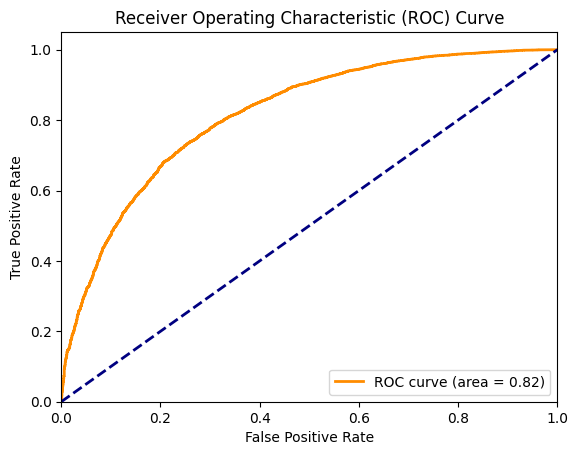

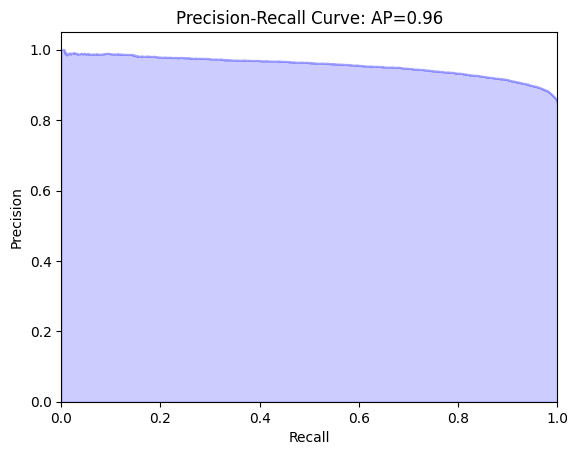

In [11]:
best_rf_evaluation_results = evaluate_model(best_rf, X_test, y_test)

In [12]:
# Save results to a JSON file
with open("../data/6-best_rf_evaluation_results.json", "w") as json_file:
    json.dump(best_rf_evaluation_results, json_file, indent=4)

# Mean Cross-Validation Score for Different Parameter Settings

In [13]:
param_grid.items()

dict_items([('n_estimators', [10, 20, 50, 75, 100, 200, 300, 500]), ('max_depth', [10, 20, 30])])

In [14]:
grid_search.cv_results_['mean_test_score']

array([0.872325 , 0.873475 , 0.8729   , 0.87335  , 0.87365  , 0.8738875,
       0.8735125, 0.8738625, 0.8673   , 0.8724625, 0.874925 , 0.8748375,
       0.87495  , 0.8763625, 0.87635  , 0.8761625, 0.8612875, 0.8697625,
       0.8733   , 0.8746375, 0.8742125, 0.8752   , 0.875325 , 0.87545  ])

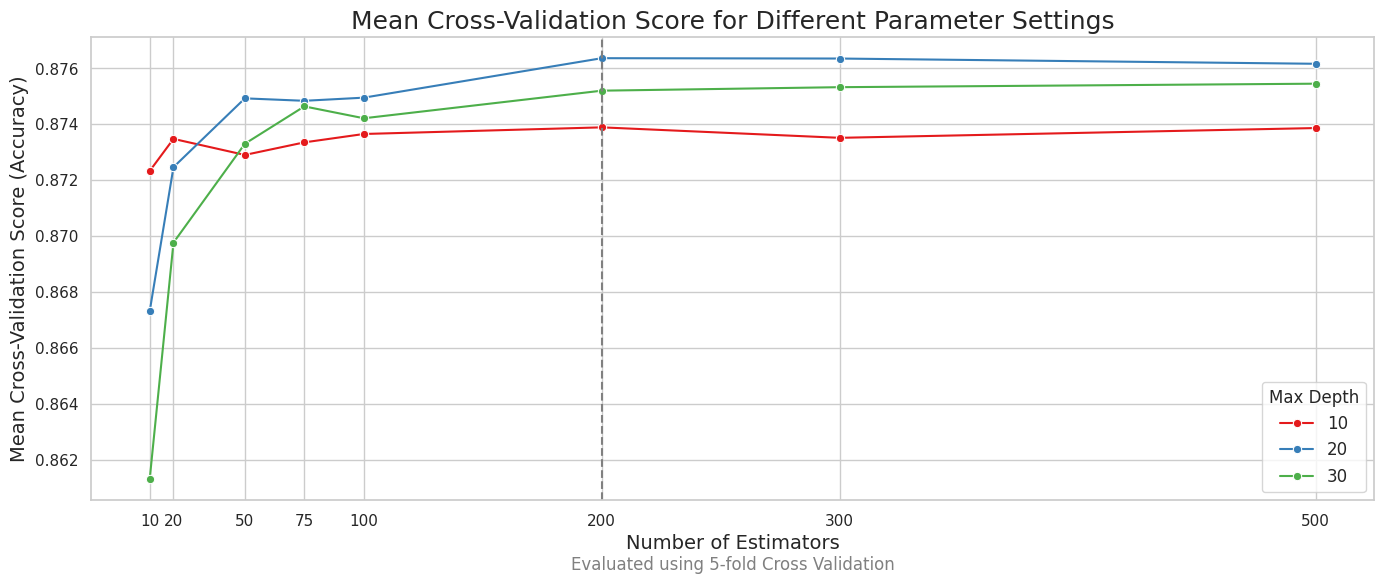

In [24]:
# Get the results of grid search
results = grid_search.cv_results_

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting the accuracy change for each parameter setting
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=results_df, 
    x='param_n_estimators', 
    y='mean_test_score', 
    hue='param_max_depth', 
    palette='Set1', 
    marker='o',
)
plt.title("Mean Cross-Validation Score for Different Parameter Settings", fontsize=18)
plt.xlabel("Number of Estimators", fontsize=14)
plt.ylabel("Mean Cross-Validation Score (Accuracy)", fontsize=14)
plt.legend(title='Max Depth', fontsize=12, loc='lower right')
plt.xticks([10, 20, 50, 75, 100, 200, 300, 500])

# Highlight x=200
plt.axvline(x=200, color='grey', linestyle='--', label='x=200')
plt.annotate('Evaluated using 5-fold Cross Validation', 
             xy=(0.5, -0.15), 
             xycoords='axes fraction', 
             ha='center', 
             fontsize=12, 
             color='gray')

plt.tight_layout()
plt.savefig("../data/6-rf-Mean Cross-Validation Score for Different Parameter Settings.png")
plt.show()

# Feature Importance

In [40]:
# Get feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame mapping feature names to their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance scores
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [41]:
sorted_feature_importance_df

,Feature,Importance
3,hours,0.172365
2,date,0.128671
15,products,0.115352
9,positive_ratio,0.110277
16,reviews,0.086000
10,user_reviews,0.083929
4,date_release,0.071951
0,helpful,0.063079
8,rating,0.049513
11,price_final,0.047454


In [42]:
sorted_feature_importance_df = sorted_feature_importance_df[:-2]

In [43]:
sorted_feature_importance_df

,Feature,Importance
3,hours,0.172365
2,date,0.128671
15,products,0.115352
9,positive_ratio,0.110277
16,reviews,0.086000
10,user_reviews,0.083929
4,date_release,0.071951
0,helpful,0.063079
8,rating,0.049513
11,price_final,0.047454


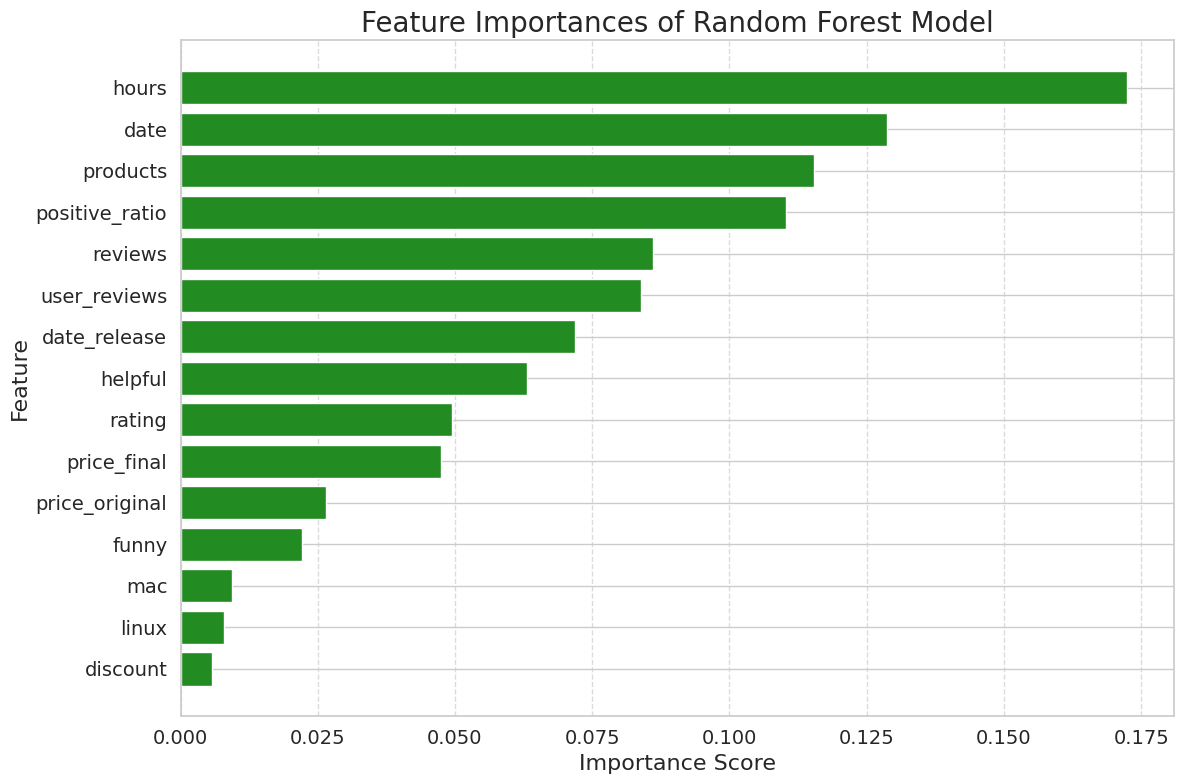

In [44]:
# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_importance_df['Feature'], sorted_feature_importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance Score', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Feature Importances of Random Forest Model', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to display features from top to bottom

plt.tight_layout()
plt.savefig("../data/6-rf-Feature Importances of Random Forest Model.png")
plt.show()